In [25]:
import xarray as xr
import numpy as np
import os.path as op
import dask.array as da
from dask.diagnostics import ProgressBar
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from scipy.interpolate import interp1d
import matplotlib.colors as clrs
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
ddir = '/swot/SUM05/takaya/MITgcm/channel/runs'

In [3]:
# 5054544*6e2/(360*86400)
# print((98*360*86400)/6e2+144)
# print((103*360*86400)/6e2+144)
ys, dy = (30,15)
dt = 6e2
ts = int(360*86400*ys/dt + 360*86400*15e0/3e2 + 360*86400*20e0/dt)
te = int(ts + dy*360*86400/dt)
print(ts,te)

4147200 4924800


In [4]:
ys, dy = (30,20)
dt = 3e2
# df = 144
# ts = int(360*86400*ys/3e2 + 360*86400*15e0/3e2)
ts = int(360*86400*ys/6e2 + 360*86400*15e0/3e2 + 360*86400*10e0/6e2 + 360*86400*10e0/dt)
te = int(ts+360*86400*dy/dt)
print(ts,te)

4665600 6739200


In [219]:
# ds1 = open_mdsdataset(op.join(ddir,'Layers_05km'), grid_dir=op.join(ddir,'5km_grid'),
#                      iters=range(ts+4320,te+4320,4320),
#                      prefix=['LAYERS-transport','LAYERS-diapycnal'],
#                      delta_t=dt
#                      )
# dstrnd = open_mdsdataset(op.join(ddir,'Layers_05km'), grid_dir=op.join(ddir,'5km_grid'),
#                         iters=range(ts,te,4320),
#                         prefix=['LAYERS-trend'],
#                         delta_t=dt
#                         )
# ds1

In [5]:
ds1 = open_mdsdataset(op.join(ddir,'Layers_05km_300s'), grid_dir=op.join(ddir,'5km_grid'),
                     iters=range(ts+8640,te+8640,8640),
                     prefix=['LAYERS-transport','LAYERS-diapycnal'],
                     delta_t=dt
                     )
# dstrnd = open_mdsdataset(op.join(ddir,'Layers_05km_300s'), grid_dir=op.join(ddir,'5km_grid'),
#                         iters=range(ts,te+8640,8640),
#                         prefix=['LAYERS-trend'],
#                         delta_t=dt
#                         )
ds1

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:              (XC: 200, XG: 200, YC: 400, YG: 400, Z: 76, Zl: 76, Zp1: 77, Zu: 76, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 240)
Coordinates:
  * XC                   (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * YC                   (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * XG                   (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * YG                   (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * Z                    (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 ...
  * Zp1                  (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 ...
  * Zu                   (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 ...
  * Zl                   (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 ...
    rA                   (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dxG                  (YG, XC) >f4 dask.array<shape=(400, 200), chunksize=(

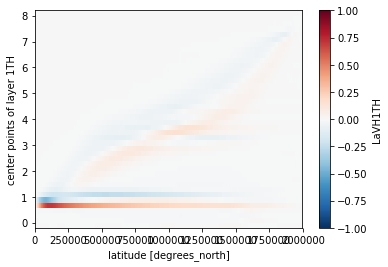

In [107]:
ds1.LaVH1TH.mean(['time','XC']).plot(vmax=1e0)

In [6]:
#### KEEP THIS (grid object when working properly)
grid = Grid(ds1, periodic=['X'])
grid

<xgcm.Grid>
T Axis (not periodic):
  * center   time (240)
Z Axis (not periodic):
  * center   Z (76) --> left
  * left     Zl (76) --> center
  * outer    Zp1 (77) --> center
  * right    Zu (76) --> center
X Axis (periodic):
  * center   XC (200) --> left
  * left     XG (200) --> center
Y Axis (not periodic):
  * center   YC (400) --> left
  * left     YG (400) --> center
1TH Axis (not periodic):
  * center   layer_1TH_center (42) --> outer
  * outer    layer_1TH_bounds (43) --> center
  * inner    layer_1TH_interface (41) --> center

In [7]:
# layer_1TH_bounds = np.array([-0.2,0.0,0.2,0.4,0.6,0.8,1.0,
#                             1.2,1.4,1.6,1.8,2.0,
#                             2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0,
#                             4.2,4.4,4.6,4.8,5.0,5.2,5.4,5.6,5.8,6.0,
#                             6.2,6.4,6.6,6.8,7.0,7.2,7.4,7.6,7.8,8.0,8.2])
# layer_1TH_center = .5*(layer_1TH_bounds[1:]+layer_1TH_bounds[:-1])
with ProgressBar():
    psi_clim = -grid.cumsum((ds1.LaVH1TH.mean('time')*ds1.dxG).sum('XC'),
                           '1TH', boundary='fill'
                           ).rename('psi').compute()
#     psi_clim = -np.cumsum((ds1.LaVH1TH.mean('time')*ds1.dxG).sum('XC'),
#                          axis=0 
#                          ).compute()
# func = interp1d(layer_1TH_center, psi_clim.data, axis=0, fill_value='extrapolate')
# psi_clim = xr.DataArray(func(layer_1TH_bounds), dims=['layer_1TH_bounds','YG'],
#                        coords={'layer_1TH_bounds':layer_1TH_bounds,'YG':ds1.YG.data}
#                        )
psi_clim

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed | 33.7s


<xarray.DataArray 'psi' (layer_1TH_bounds: 43, YG: 400)>
array([[-0.000000e+00, -0.000000e+00, -0.000000e+00, ..., -0.000000e+00,
        -0.000000e+00, -0.000000e+00],
       [-0.000000e+00, -0.000000e+00, -3.227535e+02, ..., -4.977427e+02,
        -2.116118e+02, -1.235499e+02],
       [-0.000000e+00, -0.000000e+00, -4.609933e+02, ...,  2.376080e+01,
         5.683887e+01, -6.389923e+01],
       ...,
       [-0.000000e+00, -0.000000e+00, -1.951675e-01, ..., -2.636541e+03,
        -1.464701e+03, -4.989845e+02],
       [-0.000000e+00, -0.000000e+00, -1.951675e-01, ..., -6.328125e-01,
        -4.232178e-01, -2.131653e-01],
       [-0.000000e+00, -0.000000e+00, -1.951675e-01, ..., -6.328125e-01,
        -4.232178e-01, -2.131653e-01]], dtype=float32)
Coordinates:
  * layer_1TH_bounds  (layer_1TH_bounds) >f4 -0.2 0.0 0.2 0.4 0.6 0.8 1.0 ...
  * YG                (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...

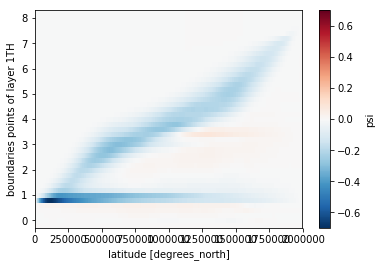

In [244]:
(psi_clim*1e-6).plot()

In [111]:
# seas = np.tile(np.repeat(range(1,5),90),dy)
# LaVH_rolled = ds1.LaVH1TH.roll(time=0)
# LaVH_rolled.coords['season'] = ('time',seas)
# LaVH1TH_seas = LaVH_rolled.groupby('season').mean('time')

# with ProgressBar():
#     psi_seas = -grid.cumsum((LaVH1TH_seas*ds1.dxG).sum('XC'),
#                            '1TH', boundary='fill'
#                            ).rename('psi').compute()
# psi_seas

In [69]:
vname = 'LaHs1TH' 
mean_thkns = ds1[vname].mean(['time','XC'])
mean_thkns[::-1]

<xarray.DataArray 'LaHs1TH' (layer_1TH_center: 42, YG: 400)>
dask.array<shape=(42, 400), dtype=float32, chunksize=(42, 400)>
Coordinates:
  * YG                (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * layer_1TH_center  (layer_1TH_center) float32 8.1 7.9 7.7 7.5 7.3 7.1 6.9 ...

[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  0.6s


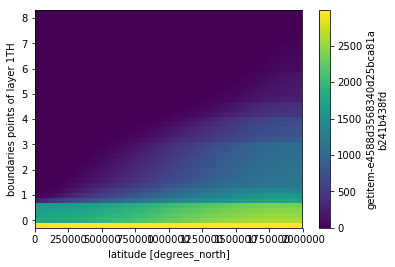

In [70]:
zb = xr.DataArray(grid.cumsum(mean_thkns[::-1], '1TH', boundary='fill')[::-1].data,
                 dims=['layer_1TH_bounds','YG'],
                 coords={'layer_1TH_bounds':ds1.layer_1TH_bounds,'YG':ds1.YG}
                 )
with ProgressBar():
    zb.plot()

In [8]:
def get_layer_depths(ds, dim, layers_name='1TH', point='s'):
    lprefix = 'layer_' + layers_name
    vname = 'LaH' + point + layers_name
    mn_thkns = ds[vname].mean(['time','XC'])
    
    # this represents the depth of the layers1TH_bounds points
    # (used as the boundaries of the center values)
    zb = xr.DataArray(grid.cumsum(mn_thkns[::-1], '1TH', boundary='fill')[::-1].data,
                     dims=['layer_1TH_bounds','YG'],
                     coords={'layer_1TH_bounds':ds.layer_1TH_bounds,'YG':ds.YG}
                     )
    
    # and this is the depth of the layers1TH_center points
    # (used as the boundaries of the interface values)
    zc = grid.interp(zb,'1TH',boundary='fill')
    
    # the interface depths
    zi = zb[1:-1].rename({lprefix+'_bounds': lprefix+'_interface'})
    
    z= {lprefix + '_bounds': zb,
        lprefix + '_center': zc,
        lprefix + '_interface': zi}
    return z[dim]

In [15]:
# def get_layer_depths(ds, dim, layers_name='1TH', point='s'):
#     lprefix = 'layer_' + layers_name
#     vname = 'LaH' + point + layers_name
#     mn_thkns = ds[vname].mean(['time','XC'])
    
#     mn_thkns = xr.DataArray(mn_thkns.data[::-1], dims=['layer_1TH_center','YG'],
#                            coords={'layer_1TH_center':layer_1TH_center[::-1],'YG':ds1.YG.data}
#                            )
#     mean_cum = np.cumsum(mn_thkns, axis=0)
#     func = interp1d(layer_1TH_center[::-1], mean_cum, axis=0, fill_value='extrapolate')
#     mean_cum = func(layer_1TH_bounds[::-1])
    
#     # this represents the depth of the layers1TH_bounds points
#     # (used as the boundaries of the center values)
# #     zb = xr.DataArray(grid.cumsum(mean_thkns[::-1], '1TH', boundary='fill')[::-1].data,
# #                      dims=['layer_1TH_bounds','YG'],
# #                      coords={'layer_1TH_bounds':ds.layer_1TH_bounds,'YG':ds.YG}
# #                      )
#     zb = xr.DataArray(mean_cum[::-1],
#                      dims=['layer_1TH_bounds','YG'],
#                      coords={'layer_1TH_bounds':layer_1TH_bounds,'YG':ds1.YG.data}
#                      )
    
#     # and this is the depth of the layers1TH_center points
#     # (used as the boundaries of the interface values)
# #     zc = grid.interp(zb,'1TH',boundary='fill')
#     zc = xr.DataArray(.5*(zb[1:].data+zb[:-1].data), dims=['layer_1TH_center','YG'], 
#                       coords={'layer_1TH_center':layer_1TH_center,'YG':ds1.YG.data})
    
#     # the interface depths
#     zi = zb[1:-1].rename({lprefix+'_bounds': lprefix+'_interface'})
    
#     z= {lprefix + '_bounds': zb,
#         lprefix + '_center': zc,
#         lprefix + '_interface': zi}
#     return z[dim]

In [9]:
z = -get_layer_depths(ds1, psi_clim.dims[0], layers_name='1TH').values
y = np.tile(ds1.YC.values[np.newaxis,:], (z.shape[0],1))

In [29]:
psi_clim

<xarray.DataArray 'psi' (layer_1TH_bounds: 43, YG: 400)>
array([[-0.000000e+00, -0.000000e+00, -0.000000e+00, ..., -0.000000e+00,
        -0.000000e+00, -0.000000e+00],
       [-0.000000e+00, -0.000000e+00, -3.227535e+02, ..., -4.977427e+02,
        -2.116118e+02, -1.235499e+02],
       [-0.000000e+00, -0.000000e+00, -4.609933e+02, ...,  2.376080e+01,
         5.683887e+01, -6.389923e+01],
       ...,
       [-0.000000e+00, -0.000000e+00, -1.951675e-01, ..., -2.636541e+03,
        -1.464701e+03, -4.989845e+02],
       [-0.000000e+00, -0.000000e+00, -1.951675e-01, ..., -6.328125e-01,
        -4.232178e-01, -2.131653e-01],
       [-0.000000e+00, -0.000000e+00, -1.951675e-01, ..., -6.328125e-01,
        -4.232178e-01, -2.131653e-01]], dtype=float32)
Coordinates:
  * layer_1TH_bounds  (layer_1TH_bounds) >f4 -0.2 0.0 0.2 0.4 0.6 0.8 1.0 ...
  * YG                (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...

In [32]:
# xr.DataArray(psi_clim, dims=['layer_1TH_bounds','YG'], 
#              coords={'layer_1TH_bounds':layer_1TH_bounds,'YG':ds1.YG.data,
#                     'z':(('layer_1TH_bounds','YG'),z),'y':(('layer_1TH_bounds','YG'),y)}
#             )
psi_clim.coords['z'] = (('layer_1TH_bounds','YG'),z)
psi_clim.coords['y'] = (('layer_1TH_bounds','YG'),y)
save = psi_clim.to_dataset(name='psi_res')
# save.coords['z'] = (('layer_1TH_bounds','YG'),z)
# save.coords['y'] = (('layer_1TH_bounds','YG'),y)
save.to_netcdf(op.join(ddir,'Climatological-psi_05km.nc'))

In [4]:
# ds2 = open_mdsdataset(op.join(ddir,'deepML-2mon_5kmKPP'), grid_dir=op.join(ddir,'5km_grid'),
#                      iters=range(ts,te,288),
#                      prefix=['KPPboundary'],
#                      delta_t=3e2
#                      )

# # with ProgressBar():
# #     MLD_clim = ds2.MXLDEPTH.mean(['time','XC']).compute()

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [10]:
MLD = xr.open_dataset(op.join(ddir,'KPPMLD_05km.nc')).mld
XLD = xr.open_dataset(op.join(ddir,'KPPhbl_99percentile_05km.nc')).hbl99
MLD

<xarray.DataArray 'mld' (time: 8280, YC: 400, XC: 200)>
[662400000 values with dtype=float32]
Coordinates:
  * XC       (XC) float32 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 ...
  * YC       (YC) float32 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 ...
    rA       (YC, XC) float32 ...
    Depth    (YC, XC) float32 ...
    iter     (time) int64 ...
  * time     (time) timedelta64[ns] 12601 days 12602 days 12603 days ...
    seas     (time) int64 ...
    months   (time) int64 ...
    day      (time) int64 ...
    month    (time) int64 ...
Attributes:
    standard_name:  MXLDEPTH
    long_name:      Mixed-Layer Depth (>0)
    units:          m

In [72]:
ds1.LaPs1TH.attrs

OrderedDict([('standard_name', 'LaPs1TH'),
             ('long_name', 'Layer Probability at V points [-]'),
             ('units', '1'),
             ('mate', 'LaPw1TH')])

In [199]:
dbl = ds1.LaPs1TH
dbl.coords['seas'] = ('time',np.tile(np.repeat(range(4),3),dy))
# MLD.coords['seas'] = ('time',np.tile(np.repeat(range(4),90),dy))
with ProgressBar():
    dbl_seas = dbl.groupby('seas').mean(['time','XC']).compute()
    MLD_seas = MLD.groupby('seas').mean(['time','XC']).compute()
    XLD_mon = XLD.groupby('month').mean(['time']).compute()

[########################################] | 100% Completed |  1.2s


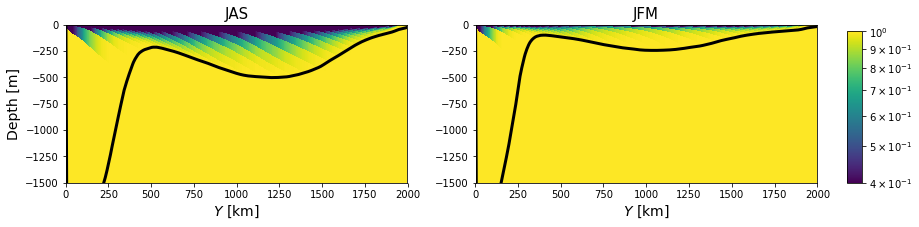

In [195]:
fig, (ax1,ax2) = plt.subplots(figsize=(14,3), nrows=1, ncols=2)
# fig.set_tight_layout(True)
im = ax1.pcolormesh(y*1e-3, z, dbl_seas[2],
                    vmin=.4, vmax=1., norm=clrs.LogNorm(), rasterized=True)
ax1.plot(MLD.YC*1e-3, -MLD_seas[2], color='k', lw=3)
ax2.pcolormesh(y*1e-3, z, dbl_seas[0], 
               vmin=.4, vmax=1., norm=clrs.LogNorm(), rasterized=True)
ax2.plot(MLD.YC*1e-3, -MLD_seas[0], color='k', lw=3)
ax1.set_ylim([-1500,0])
ax2.set_ylim([-1500,0])
ax1.set_xlabel(r'$Y$ [km]', fontsize=14)
ax1.set_ylabel(r'Depth [m]', fontsize=14)
ax2.set_xlabel(r'$Y$ [km]', fontsize=14)
ax1.set_title(r'JAS', fontsize=15)
ax2.set_title(r'JFM', fontsize=15)
fig.subplots_adjust(right=0.87)
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig(op.join(ddir,'Figures/DiabLayer_05km_seasclim.pdf'))

In [14]:
# days = ('time',np.tile(np.repeat(range(12),30),dy))
# print(len(np.tile(np.repeat(range(12),30),dy)))
# MLD = ds2.MXLDEPTH.mean('XC')
# hbl = ds2.KPPhbl
# hbl99 = xr.DataArray(np.percentile(hbl, 99, axis=-1), dims=['time','YC'],
#                     coords={'time':ds2.time,'YC':ds2.YC})
# MLD.coords['day'] = days
# hbl99.coords['day'] = days
# with ProgressBar():
#     MLD_mon = MLD.groupby('day').mean('time').compute()
#     hbl99_mon = hbl99.groupby('day').mean('time').compute()
# # hbl_mon
# hbl99_mon

In [ ]:
# fig, ax = plt.subplots(figsize=(8,5))
# ax.plot(MLD_clim.YC*1e-3, -MLD_clim, 'k', lw=3)
# ax.plot(hbl99.YC*1e-3, (-hbl99).mean('time'), 'k--')

In [ ]:
# seasons = np.tile(np.repeat(range(4),90),dy)
# hbl99.coords['season'] = ('time',seasons)
# with ProgressBar():
#     hbl99_seas = hbl99.groupby('season').mean('time').compute()
# hbl99_seas

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


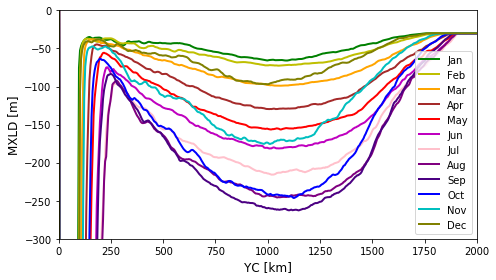

In [205]:
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']
month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
for i in range(12):
    ax.plot(XLD_mon.YC*1e-3, -XLD_mon[i], lw=2, color=colors[i], label=month[i])
ax.legend(loc='lower right', fontsize=10)
ax.set_xlim([0.,2e3])
ax.set_ylim([-300,0.])
ax.set_xlabel(r'YC [km]', fontsize=12)
ax.set_ylabel(r'MXLD [m]', fontsize=12)
plt.savefig(op.join(ddir,'Figures/XLD_05km_month-clim.pdf'))

In [187]:
# MLD10 = xr.open_dataarray(op.join(ddir,'MLD_10km_zonalave.nc')).groupby('DinM').mean('time').compute()

# fig, ax = plt.subplots(figsize=(6,4))
# fig.set_tight_layout(True)
# ax.plot(MLD_mon.YC*1e-3, -MLD_mon[7], lw=2, color='b', ls='--', label=r'MLD$_{5km}$ (Aug)')
# ax.plot(MLD_mon.YC*1e-3, -MLD_mon[1], lw=2, color='r', ls='--', label=r'MLD$_{5km}$ (Feb)')
# ax.plot(hbl99_mon.YC*1e-3, -hbl99_mon[7], lw=2, color='b', ls=':', label=r'MXLD$_{5km}$ (Aug)')
# ax.plot(hbl99_mon.YC*1e-3, -hbl99_mon[1], lw=2, color='r', ls=':', label=r'MXLD$_{5km}$ (Feb)')
# ax.plot(MLD10.YC*1e-3, -MLD10[7], lw=2, color='b', label=r'MLD$_{10km}$ (Aug)')
# ax.plot(MLD10.YC*1e-3, -MLD10[1], lw=2, color='r', label=r'MLD$_{10km}$ (Feb)')
# ax.legend(loc='lower right', fontsize=12)
# ax.set_xlabel(r'YC [km]', fontsize=14)
# ax.set_ylabel(r'MLD [m]', fontsize=14)
# plt.savefig(op.join(ddir,'Figures/MLD_5km_Jan_Sep-clim.pdf'))

In [11]:
# dsT = open_mdsdataset(op.join(ddir,'deepML-2mon_5kmTtave'), grid_dir=op.join(ddir,'5km_grid'),
#                      iters=range(ts-288+8640,te,8640),
#                      prefix=['Ttave'], delta_t=6e2
#                      )
# dsT_clim = dsT.mean(['time','XC'])
# with ProgressBar():
#     dsT_clim.load()
# Ttave = dsT.Ttave.mean('XC')
# seasons = np.tile(np.repeat(range(4),3),dy)
# Ttave.coords['season'] = ('time',seasons)
# with ProgressBar():
#     T_seas = Ttave.groupby('season').mean('time').compute()
# T_seas
T_clim = xr.open_dataset(op.join(ddir,'Climatological-theta_05km.nc')).THETA_clim
T_clim

<xarray.DataArray 'THETA_clim' (Z: 76, YC: 400)>
array([[ 0.      ,  0.742695,  0.752953, ...,  7.873117,  7.905392,  7.936736],
       [ 0.      ,  0.743899,  0.754124, ...,  7.644438,  7.682634,  7.715763],
       [ 0.      ,  0.744381,  0.754587, ...,  7.484123,  7.51533 ,  7.543954],
       ...,
       [ 0.      , -0.523288, -0.523166, ..., -0.075829, -0.081848, -0.08487 ],
       [ 0.      , -0.523955, -0.523825, ..., -0.413069, -0.418189, -0.421798],
       [ 0.      , -0.524241, -0.524087, ..., -0.498597, -0.498566, -0.498589]],
      dtype=float32)
Coordinates:
  * YC       (YC) float32 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 ...
  * Z        (Z) float32 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
    drF      (Z) float32 ...
    PHrefC   (Z) float32 ...

In [93]:
alpha = 2e-4
g = 9.81
N2 = alpha*g * (grid.diff(T_clim, 'Z', boundary='fill', to='outer')
                / grid.diff(T_clim.Z, 'Z', boundary='fill', to='outer')
               )
# N2_seas = alpha*g * grid.interp(grid.diff(T_seas, 'Z', boundary='fill')
#                                / grid.diff(T_seas.Z, 'Z', boundary='fill'), 
#                                'Z', boundary='fill')
N2

<xarray.DataArray (Zp1: 77, YC: 400)>
array([[-0.000000e+00, -2.914336e-03, -2.954588e-03, ..., -3.089411e-02,
        -3.102076e-02, -3.114375e-02],
       [-0.000000e+00, -2.206531e-06, -2.147731e-06, ...,  4.193155e-04,
         4.084587e-04,  4.051860e-04],
       [-0.000000e+00, -7.751875e-07, -7.442260e-07, ...,  2.578181e-04,
         2.690571e-04,  2.763030e-04],
       ...,
       [-0.000000e+00,  9.971032e-09,  9.844625e-09, ...,  5.036668e-06,
         5.023234e-06,  5.032004e-06],
       [-0.000000e+00,  3.611314e-09,  3.313947e-09, ...,  1.080250e-06,
         1.015190e-06,  9.699017e-07],
       [ 0.000000e+00,  3.531342e-07,  3.530305e-07, ...,  3.358602e-07,
         3.358392e-07,  3.358548e-07]], dtype=float32)
Coordinates:
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * YC       (YC) float32 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


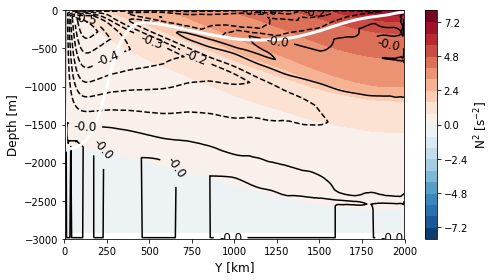

In [17]:
psilevs = np.arange(-.8,.9,0.1) + 0.

fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
# ax1.plot(Q.YC*1e-3, Q.mean(['time','XC']), 'k', lw=2)
# ax1.set_xlim([0,1995.])
# ax1.set_ylabel(r"Q [w m$^{-2}$]", fontsize=12)
im = ax.contourf(T_clim.YC*1e-3, T_clim.Z, T_clim,
                levels=np.linspace(-8,8,21), cmap='RdBu_r')
ct = ax.contour(y*1e-3, z, psi_clim*1e-6,
               colors='k', levels=psilevs, extend='both')
ax.plot(MLD.YC*1e-3, -MLD.mean(['time','XC']), color='white', lw=3)
ax.set_xlabel(r'Y [km]', fontsize=12)
ax.set_ylabel(r'Depth [m]', fontsize=12)
ax.set_ylim([-3e3,0])
plt.clabel(ct, inline=1, fmt='%1.1f', fontsize=12)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'N$^2$ [s$^{-2}$]', fontsize=12)
plt.savefig(op.join(ddir,'Figures/Overturning-psi_05km_dT300s.pdf'))

In [176]:
# fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(11,9))
# fig.set_tight_layout(True)
# im = axes[0,0].pcolormesh(T_seas.YC*1e-3, T_seas.Z.data, 
#                          N2_seas[2],
#                          norm=clrs.LogNorm(), vmin=2e-8, vmax=2e-5, rasterized=True)
# cm1 = axes[0,0].contour(T_seas.YC*1e-3, T_seas.Z, T_seas[2], 15, colors='k')
# axes[0,0].plot(T_seas.YC*1e-3, -MLD_seas[2], 'w', lw=2)
# axes[0,1].pcolormesh(T_seas.YC*1e-3, T_seas.Z.data, 
#                     N2_seas[-1],
#                     norm=clrs.LogNorm(), vmin=2e-8, vmax=2e-5, rasterized=True)
# cm2 = axes[0,1].contour(T_seas.YC*1e-3, T_seas.Z, T_seas[-1], 15, colors='k')
# axes[0,1].plot(T_seas.YC*1e-3, -MLD_seas[-1], 'w', lw=2)
# axes[1,0].pcolormesh(T_seas.YC*1e-3, T_seas.Z.data, 
#                     N2_seas[2],
#                     norm=clrs.LogNorm(), vmin=2e-8, vmax=2e-5, rasterized=True)
# cm3 = axes[1,0].contour(T_seas.YC*1e-3, T_seas.Z, T_seas[0], 15, colors='k')
# axes[1,0].plot(T_seas.YC*1e-3, -MLD_seas[0], 'w', lw=2)
# axes[1,1].pcolormesh(T_seas.YC*1e-3, T_seas.Z.data, 
#                     N2_seas[1],
#                     norm=clrs.LogNorm(), vmin=2e-8, vmax=2e-5, rasterized=True)
# cm4 = axes[1,1].contour(T_seas.YC*1e-3, T_seas.Z, T_seas[1], 15, colors='k')
# axes[1,1].plot(T_seas.YC*1e-3, -MLD_seas[1], 'w', lw=2)

# axes[0,0].set_title(r"JAS", fontsize=15)
# axes[0,1].set_title(r"OND", fontsize=15)
# axes[1,0].set_title(r"JFM", fontsize=15)
# axes[1,1].set_title(r"AMJ", fontsize=15)
# # axes[0,0].set_xticklabels([])
# # axes[0,1].set_xticklabels([])
# # axes[0,1].set_yticklabels([])
# # axes[1,1].set_yticklabels([])
# axes[0,0].set_ylim([ds.Zp1.min(),0.])
# axes[0,1].set_ylim([ds.Zp1.min(),0])
# axes[1,0].set_ylim([ds.Zp1.min(),0])
# axes[1,1].set_ylim([ds.Zp1.min(),0])
# plt.clabel(cm1, inline=1, fontsize=12)
# plt.clabel(cm2, inline=1, fontsize=12)
# plt.clabel(cm3, inline=1, fontsize=12)
# plt.clabel(cm4, inline=1, fontsize=12)
# # ax.set_title(r'N$^2$ w/ temperature contour')
# cbar_ax = fig.add_axes([0.99, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.set_label(r'N$^2$ [s$^{-2}$]', fontsize=14)

# # fig.subplots_adjust(right=0.8, bottom=0.2)
# fig.text(0.01, 0.5, 'Depth [m]', 
#          va='center', rotation='vertical', fontsize=17)
# fig.text(0.48, 0.01, 'Y [km]', 
#          va='center', rotation='horizontal', fontsize=17)

# plt.savefig(op.join(ddir,'LocaldeepML_seasonal-stratification.pdf'))

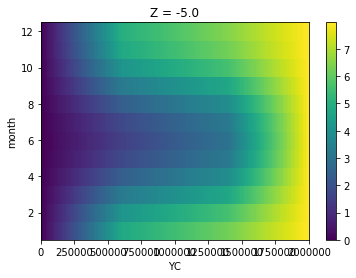

In [104]:
dtype = '>f8'
shape = (12,40,200,100)
Trelax = np.fromfile(op.join(ddir,'zerores_-2monDML_Ttave/rbcs_SSTandNB-relax_zero-res_-2mon_010km.bin'), 
                    dtype=dtype)
Trelax.shape = shape
Trelax = xr.DataArray(Trelax, dims=['month','Z','YC','XC'],
                     coords={'month':range(1,13),'Z':ds.Z.data,'YC':ds.YC.data,'XC':ds.XC.data}
                     )
Trelax[:,0].mean('XC').plot()

In [19]:
# cp = 3994.  #[J kg-1 K-1]
# rho0 = 999.8  #[kg m-3]
# tau = 3e1*86400  #[s]
# C = rho0*cp*ds.drF[0]*ds.hFacC[0]*tau**-1
# sst = dsT.Ttave[:,0]
# Q = xr.DataArray(np.zeros_like(sst), dims=sst.dims,
#                 coords=sst.coords)

# for i in range(5):
#     for j in range(12):
#         Q[i*12+j] = (-sst[i*12+j] + Trelax[j,0]) * C
tsSF = int(35*360*86400/dt)
teSF = int(tsSF + 15*360*86400/dt)
print(teSF)

dsurf = open_mdsdataset(op.join(ddir,'SurfForc_05km'), grid_dir=op.join(ddir,'5km_grid'),
                       iters=range(tsSF+8640,teSF+8640,8640), prefix=['SurfForc'], delta_t=3e2
                       )
Q = dsurf.TFLUX
Q

5184000


/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.DataArray 'TFLUX' (time: 180, YC: 400, XC: 200)>
dask.array<shape=(180, 400, 200), dtype=float32, chunksize=(1, 400, 200)>
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
    rA       (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    Depth    (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    iter     (time) int64 dask.array<shape=(180,), chunksize=(1,)>
  * time     (time) float64 1.091e+09 1.094e+09 1.096e+09 1.099e+09 ...
Attributes:
    standard_name:  TFLUX
    long_name:      total heat flux (match heat-content variations), >0 incre...
    units:          W/m^2

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


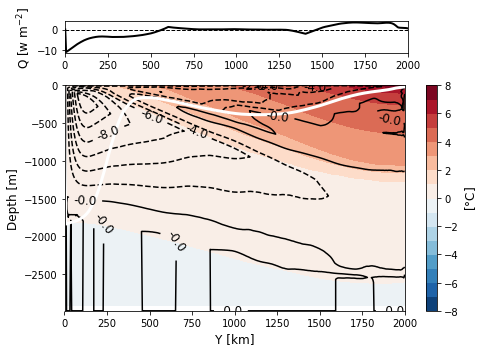

In [24]:
psilevs = np.arange(-.8,.9,0.1)*20 + 0.
Tclim = xr.open_dataset(op.join(ddir,'Climatological-theta_05km.nc')).THETA_clim

fig = plt.figure(figsize=(7,5))
# fig.set_tight_layout(True)
ax1 = plt.subplot2grid((5,11),(0,0),colspan=9)
ax2 = plt.subplot2grid((5,11),(1,0),rowspan=4,colspan=11)
fig.set_tight_layout(True)
ax1.plot(Q.YC*1e-3, Q.mean(['time','XC']), 'k', lw=2)
ax1.plot(Q.YC*1e-3, np.zeros(len(Q.YC)), 'k--', lw=1)
ax1.set_xlim([0,2e3])
ax1.set_ylabel(r"Q [w m$^{-2}$]", fontsize=12)
# im = ax2.pcolormesh(N2.YC*1e-3, N2.Zp1, N2,
#                    norm=clrs.LogNorm(), vmin=2e-8, vmax=2e-5, rasterized=True)
im = ax2.contourf(T_clim.YC*1e-3, T_clim.Z, T_clim,
                levels=np.linspace(-8,8,17), cmap='RdBu_r')
ct = ax2.contour(y*1e-3, z, psi_clim*1e-6*2e1,
                colors='k', levels=psilevs, extend='both')
ax2.plot(MLD.YC*1e-3, -MLD.mean(['time','XC']), color='white', lw=3)
ax1.set_xlim([0,2e3])
ax2.set_xlabel(r'Y [km]', fontsize=12)
ax2.set_ylabel(r'Depth [m]', fontsize=12)
plt.clabel(ct, inline=1, fmt='%1.1f', fontsize=12)
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label(r'[$\degree$C]', fontsize=12)
plt.savefig(op.join(ddir,'Figures/DeeplocalML_05km_overturning.pdf'))

In [229]:
def thickness_budget(ds, ds_trend, layer_name='1TH'):
    """Calculate thickness budget from layers data in xarray format."""
    grid = Grid(ds, periodic=['X', 'Y'])    
    dsnew = {}
    
    diapycnal_map = {
        'surface_forcing': (('LaTs',), 1),
        'mixing_vertical': (('LaTz',), 1),
        'mixing_horizontal': (('LaTh',), 1),
        'advection_tendency': (('LTha', 'LTza'), 1),
        'total_tendency': (('LTto',), (24*60*30.)**-1)
    }
    
    for name, (components, scalefac) in diapycnal_map.items():
        if len(components)>1:
            w = sum(*[ds[cpt + layer_name] for cpt in components])
        else:
            w = ds[components[0] + layer_name]
        w_diff = grid.diff(scalefac * w * ds.rA, layer_name, boundary='fill')
        # we want CONVERGENCE, not divergence, so need a minus sign
        dsnew[name + '_' + layer_name] = -w_diff
        
    # we want CONVERGENCE, not divergence, so need a minus sign
    dsnew['advection_flux' + '_' + layer_name] = (
        - grid.diff(ds['LaVH' + layer_name] * ds.dxG, 'Y')
        - grid.diff(ds['LaUH' + layer_name] * ds.dyG, 'X') )
    
    dsnew['thickness_trend' + '_' + layer_name] = (
        ds_trend.LaHc1TH.diff(dim='time', label='upper') /
        ds_trend.time.diff(dim='time', label='upper') ) * ds.rA
    
    dsnew['mixing_numerical' + '_' + layer_name] = (
        dsnew['advection_tendency' + '_' + layer_name] -
        dsnew['advection_flux' + '_' + layer_name] )

    return xr.Dataset(dsnew)

In [232]:
ds_tb = thickness_budget(ds1, dstrnd)
ds_tb

<xarray.Dataset>
Dimensions:                 (XC: 200, YC: 400, layer_1TH_center: 42, time: 240)
Coordinates:
  * time                    (time) float64 1.402e+09 1.405e+09 1.407e+09 ...
  * layer_1TH_center        (layer_1TH_center) float32 -0.1 0.1 0.3 0.5 ...
  * YC                      (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * XC                      (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
    rA                      (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    Depth                   (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    iter                    (time) int64 dask.array<shape=(240,), chunksize=(1,)>
Data variables:
    surface_forcing_1TH     (time, layer_1TH_center, YC, XC) float32 dask.array<shape=(240, 42, 400, 200), chunksize=(1, 1, 400, 200)>
    mixing_vertical_1TH     (time, layer_1TH_center, YC, XC) float32 dask.array<shape=(240, 42, 400, 200), chunksize=(1, 1, 400, 200)>
    mixing_horizontal_1TH  

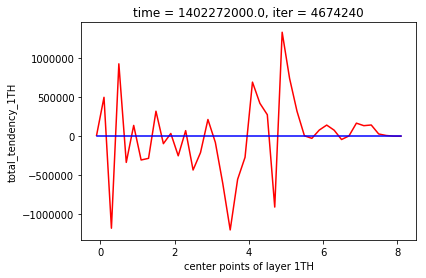

In [252]:
ds_tb.thickness_trend_1TH[0].sum(dim=['YC','XC']).plot(color='r')
ds_tb.total_tendency_1TH[0].sum(dim=['YC','XC']).plot(color='b')

In [235]:
# calculate numerical mixing
ds1['w_numerical'] = grid.cumsum(ds_tb.mixing_numerical_1TH, '1TH', to='inner') / ds1.rA
ds1['w_true_trend'] = grid.cumsum(ds_tb.thickness_trend_1TH, '1TH', to='inner') / ds1.rA

In [246]:
net = ds1.LaTs1TH + ds1.LaTz1TH + ds1.LaTh1TH + ds1.w_numerical
with ProgressBar():
    net = (net * ds1.rA).mean(dim='time').sel(YC=slice(0.,17.5e5)).sum(dim=('XC','YC')).compute()*1e-6
    surf = (ds1.LaTs1TH * ds1.rA).mean(dim='time').sel(YC=slice(0.,17.5e5)).sum(dim=('XC','YC')).compute()*1e-6
    vert = (ds1.LaTz1TH * ds1.rA).mean(dim='time').sel(YC=slice(0.,17.5e5)).sum(dim=('XC','YC')).compute()*1e-6
    hori = (ds1.LaTh1TH * ds1.rA).mean(dim='time').sel(YC=slice(0.,17.5e5)).sum(dim=('XC','YC')).compute()*1e-6
    numi = (ds1.w_numerical * ds1.rA).mean(dim='time').sel(YC=slice(0.,17.5e5)).sum(dim=('XC','YC')).compute()*1e-6

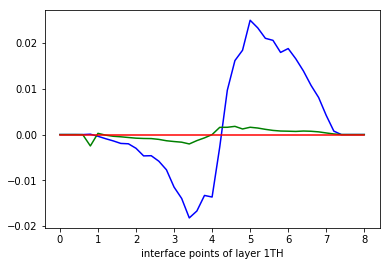

In [250]:
fig, ax = plt.subplots()
# net.plot(ax=ax, color='m')
surf.plot(ax=ax, color='b')
vert.plot(ax=ax, color='g')
hori.plot(ax=ax, color='r')
# numi.plot(ax=ax, color='c')

NameError: name 'run_name' is not defined

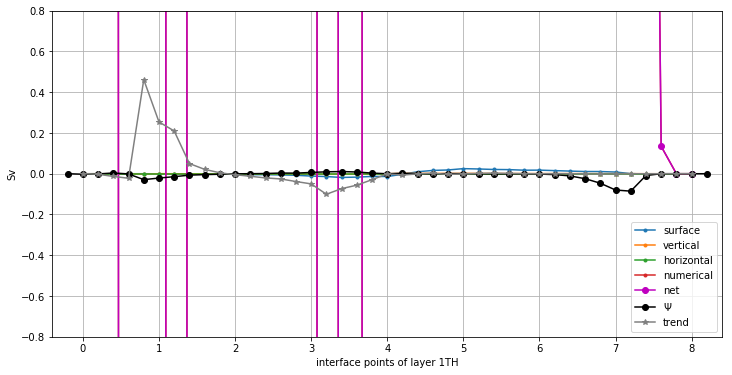

In [237]:
def plot_transformation(array, ax, ymax=17.5e5, **kwargs):
    omega = (array * ds1.rA).mean(dim='time').sel(YC=slice(0,ymax)).sum(dim=('XC','YC'))*1e-6
    omega.plot(ax=ax, **kwargs)

fig, ax = plt.subplots(figsize=(12,6))

plot_transformation(ds1.LaTs1TH, ax, marker='.', label='surface')
plot_transformation(ds1.LaTz1TH, ax, marker='.', label='vertical')
plot_transformation(ds1.LaTh1TH, ax, marker='.', label='horizontal')
plot_transformation(ds1.w_numerical, ax, marker='.', label='numerical')

net = (ds1.LaTs1TH + ds1.LaTz1TH + ds1.LaTh1TH + ds1.w_numerical)
plot_transformation(net, ax, marker='o', color='m', label='net')

p = psi_clim.sel(YC=17.5e5, method='nearest')*1e-6
p.plot(ax=ax, marker='o', color='k', label=r'$\Psi$')

#plot_transformation(ds.LTto1TH/(24*60*60), ax, marker='*', color='0.5', label='trend')
plot_transformation(ds1.w_true_trend, ax, marker='*', color='0.5', label='trend')

plt.ylim([-0.8, 0.8])
plt.grid()
plt.ylabel('Sv')
plt.legend()
# plt.title('Tranformation : ' + run_name)
#plt.savefig('figures/channel_%s_transformation.pdf' % run_name)

In [254]:
2592*12

31104